In [2]:
import numpy as np
%matplotlib inline
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

In [3]:
def is_pos_def(x):
        return np.all(np.linalg.eigvalsh(x) > 0)

def norm_points(points, high=None, low=None):
    if high is None:
        high = np.max(points)
    if low is None:
        low = np.min(points)
    return (points-low)/float(high - low)

def cor(x, x_prime, delta, p=2):
    #print delta
    #res = np.exp(-np.add.reduce(map(lambda x_k, x_prime_k, delta_k: np.power((x_k-x_prime_k)/delta_k, 2), np.hsplit(x, p), np.vsplit(x_prime, p), delta)))
    res = np.exp(-np.add.reduce(np.power((np.array(np.hsplit(x, p))-np.array(np.vsplit(x_prime, p)))/delta[:,np.newaxis][:,np.newaxis], 2)))
    #res = np.exp(-(np.power(((np.array(np.hsplit(x, p))-np.array(np.vsplit(x_prime, p)))[0]/delta[0]), 2) + np.power(((np.array(np.hsplit(x, p))-np.array(np.vsplit(x_prime, p)))[1]/delta[1]), 2)))
    return res

def cov(x, x_prime, delta, sigma_squared):
    return sigma_squared*cor(x, x_prime, delta)

def pi_star_delta(sigma_hat_sq, n, q, A_inv, A, H):
    return np.power(sigma_hat_sq, -(n-q)/2.)*np.power(np.linalg.det(A), -1/2.)*np.power(np.linalg.det(H.T.dot(A_inv).dot(H)), -1/2.)

def sigma_hat_sq(n, q, f_D, A_inv, H):
    #print f_D.T.dot(A_inv-A_inv.dot(H).dot((H.T.dot(A_inv).dot(H)).getI()).dot(H.T).dot(A_inv)).dot(f_D)
    #print n-q-2
    res = f_D.T.dot(A_inv-A_inv.dot(H).dot((H.T.dot(A_inv).dot(H)).getI()).dot(H.T).dot(A_inv)).dot(f_D)/(n-q-2.)
    return res

def sigma_hat_sq_beta(n, q, f_D, A_inv, H_, beta_hat):
    return ((f_D-H_.dot(beta_hat)).T.dot(A_inv).dot(f_D-H_.dot(beta_hat)))/(n-q-2.)

def A(points, delta, p):
    res = cor(points.T, points, delta, p)
    """try:
        np.linalg.cholesky(res)
    except LinAlgError:
        print delta
        print np.linalg.eigvalsh(res)
        raise"""
    return res

def A_tau(points, tau, p):
    return
    

def tau(delta):
    return 2*np.log(delta)

def pi_star_tau(n, q, f_D, A_inv, A, H):
    return pi_star_delta(sigma_hat_sq(n, q, f_D, A_inv, H), n, q, A_inv, A, H)

def H(x, h):
    return h(x).T

def beta_hat(H, A_inv, f_D):
    return (H.T.dot(A_inv).dot(H)).getI().dot(H.T).dot(A_inv).dot(f_D)

def h(x):
    return np.vstack((np.ones(x.shape[1]), x))

def mahalanobis(f_D, m_star, v_star):
    return (f_D - m_star).T.dot(v_star.getI()).dot(f_D - m_star)

def se(f_D, m_star, v_star):
    return (f_D - m_star).T / np.sqrt(np.diag(v_star))

def make_t(D, delta_hat):
    def f(x):
        return cor(D.T, x, delta_hat)
    return f

def make_m_star(h, b_hat, A_inv, f_D, t):
    def f(x):
        return h(x).T.dot(b_hat) + t(x).T.dot(A_inv).dot(f_D - H_.dot(b_hat))
    return f

def make_v_star(d_hat_sq, delta_hat, A_inv, h, H_, t):    
    def f(x, x_prime):
        return d_hat_sq*(cor(x.T, x_prime, delta_hat) - t(x).T.dot(np.array(A_inv, dtype=np.float_)).dot(t(x_prime)) + (h(x).T-t(x).T.dot(A_inv).dot(H_)).dot(H_.T.dot(A_inv.dot(H_)).getI()).dot((h(x_prime).T-t(x_prime).T.dot(A_inv.dot(H_))).T))
    return f

def W(H, A_inv):
    return (H.T.dot(A_inv).dot(H)).getI()

def G(A_inv, H):
    return A_inv.dot(H)

def e(A_inv, f_F, H, beta_hat):
    return A_inv.dot(f_D - H.dot(beta_hat))

def E(r_h, b_hat, r_t, e):
    return r_h.T.dot(b_hat) + r_t.T.dot(e)

def V(sigma, u, r_t, A_inv, r_h, g, w):
    return sigma*(u - r_t.T.dot(A_inv).dot(r_t) + ((r_h - g.T.dot(r_t)).T.dot(w).dot(r_h-g.T.dot(r_t))))

def E_var(i_i, i_2, V_, E_):
    return (i_i-v) + (i_2 - np.power(E_, 2.))

def posterior_mean_m_w(r_w, b_hat, t_w, e_):
    return r_w.dot(b_hat) + t_w.dot(e_)

def posterior_mean_i(r_i, r_h, t_i, r_t, b_hat, e_):
    """
    Main effects
    """
    return (r_i - r_h.T).dot(b_hat) + (t_i - r_t.T).dot(e_)

def posterior_mean_ij(r_ij, r_i, r_j, r, b_hat, t_ij, t_i, t_j, t, e_):
    """
    Interaction effects
    """
    return (r_ij - r_i - r_j - r).dot(b_hat) + (t_ij - t_i - t).dot(e_)

def posterior_mean_v_w(sigma, beta, A_inv, e_, w, H, u, u_w, p_w, q_w, r, t):
    """
    Sensitivity variance
    """
    term = q_w - s_w.dot(A_inv).dot(H) 
    term -= H.T.dot(A_inv).dot(s_w.T) 
    term += H.T.dot(A_inv).dot(p_w).dot(A_inv).dot(H)
    
    result = u_w-np.trace(A_inv.dot(p_w)) 
    result += np.trace(w.dot(term))
    result *= sigma
    result += e_.T.dot(p_w).dot(e_)
    result += 2*beta.T.dot(s_w).dot(e_)
    result += beta.T.dot(q_w).dot(beta)
    #second term
    rtah = r-t.dot(A_inv).dot(H)
    result -= sigma*(u-t.dot(A_inv).dot(t.T) + rtah.dot(w).dot(rtah.T))
    result -= np.power(r.dot(beta) + t.dot(e_), 2.)
    return result

def posterior_mean_v_tw():
    return

def I_1(sigma, A_inv, r_tt, w, r_hh, r_ht, g):
    return sigma*(1-np.trace(A_inv.dot(r_tt)) + np.trace(w.dot(r_hh - 2*r_ht.dot(g) + g.T.dot(r_tt).dot(g))))

def I_2(beta, r_hh, r_ht, e_, r_tt):
    return beta.T.dot(r_hh).dot(beta) + 2*beta.T.dot(r_ht).dot(e_) + e_.T.dot(r_tt).dot(e_)

def I_3(sigma_quad, s_, A_inv, u_tt, r_tt, r_ht, w, u_hh, u_ht, g):
    return sigma_quad*(s_ - 2*np.trace(A_inv).dot(u_tt) + t*r*A_inv.dot(r_tt).dot(A_inv).dot(r_tt) + 2*t*r*w.dot(u_hh - 2*u_ht.dot(u) + g.T.dot(u_tt).dot(g)) - 2*t*r*A_inv.dot(r_ht-g.T.dot(r_tt)).T.dot(w).dot(r_ht-g.T.dot(r_tt)) + t*r*w.dot(r_hh - 2*r_ht.dot(g) + g.T.dot(r_tt).dot(g)).dot(w).dot(r_hh - 2*r_ht.dot(g) + g.T.dot(r_tt).dot(g)))

def I_4(sigma, beta, U_hh, U_ht, U_tt, e, R_ht, R_tt, R_hh, G, W, A_inv):
    return sigma*(beta.T.dot(U_hh).dot(beta) + 2*beta.T.dot(U_ht).dot(e) + e.T.dot(U_tt).dot(e) - beta.T.dot(R_ht).dot(A_inv).dot(R_ht.T).dot(beta) - 2*beta.T.dot(R_ht).dot(A_inv).dot(R_tt).dot(e) - e.T.dot(R_tt).dot(A_inv).dot(R_tt).dot(e) + (R_hh.dot(beta) - G.T.dot(R_ht.T).dot(beta) + R_ht.dot(e) -G.T.dot(R_tt).dot(e)).T.dot(W).dot(R_hh.dot(beta) - G.T.dot(R_ht.T).dot(beta) + R_ht.dot(e) - G.T.dot(R_tt).dot(e)))

def I_5(sigma_quad, S, A_inv, U_t, U_h, R_ht, R_t, R_tt, R_h, G, W):
    return delta_quad*(S-2*R_t.T.dot(A_inv).dot(U_t) + R_t.T.dot(A_inv).dot(R_tt).dot(A_inv).dot(R_t) + 2*(U_h - G.T.dot(U_t)).T.dot(W).dot(R_h - G.T.dot(R_t)) - 2*R_t.T.dot(A_inv).dot(R_ht.T-R_tt.dot(G)).dot(W).dot(R_h - G.T.dot(R_t)) + (R_h - G.T.dot(R_t)).T.dot(W).dot(R_hh - 2*R_ht.dot(G) + G.T.dot(R_tt).dot(G)).dot(W).dot(R_h - G.T.dot(R_t)))

def I_6(sigma, beta, U_h, U_t, R_ht, R_t, R_hh, R_h, A_inv, G, W, e):
    return sigma*(beta.T.dot(U_h) - beta.T.dot(R_ht).dot(A_inv).dot(R_t) + beta.T.dot(R_hh - R_ht.dot(G)).dot(W).dot(R_h - G.T.dot(R_t)) + e.T.dot(U_t) - e.T.dot(R_tt).dot(A_inv).dot(R_t) + e.T.dot((R_ht - G.T.dot(R_tt)).T).dot(W).dot(R_h - G.T.dot(R_t)))

def Q_k(x, xk, m, B, C):
    return 2*(x - xk).T.dot(C.dot(x - xk)) + (x-m).T.dot(B).dot(x-m)

def m_k(x, C, B, m):
    return (2*C + B).getI().dot(2*C.dot(x) + B.dot(m))

def R_h(m):
    return np.vstack(([1], m))

def R_hh(m, B):
    return np.vstack((np.hstack(([[1]], m.T)), np.hstack((m, m.dot(m.T) + B.getI()))))

def R_t(X, k, B, C, v, m):
    X = X[:,k][:,np.newaxis]
    m_prime_k = m_k(X, C, B, m)
    q_k = Q_k(m_prime_k, X, m, B, C)
    
    return (1-v)*np.power(np.linalg.det(B), 0.5)*np.power(np.linalg.det(2*C + B), -0.5)*np.exp(-q_k/2.)

def R_ht(X, k, B, C, v, m, h):
    x = X[:,k][:,np.newaxis]
    m_prime_k = m_k(x, C, B, m)
    return R_t(X, k, B, C, v, m)[0,0]*np.vstack(([1], m_prime_k))

def Q_kl(x, xk, xl, C, B, m):
    return 2*(x - xk).T.dot(C).dot(x - xk) + 2*(x - xl).T.dot(C).dot(x - xl) + (x - m).T.dot(B).dot(x - m)

def m_kl(xk, xl, C, B, m):
    return (4*C + B).getI().dot(2*C.dot(xk) + 2*C.dot(xl) + B.dot(m))

def R_tt(x, k, l, C, B, m, v):
    xk = x[:,k][:,np.newaxis]
    xl = x[:,l][:,np.newaxis]
    qkl = Q_kl(m_kl(xk, xl, C, B, m), xk, xl, C, B, m)
    return np.power(1-v, 2.)*np.power(np.linalg.det(B), 0.5)*np.power(np.linalg.det(4*C + B), -0.5)*np.exp(- qkl/2.)

def Q(x, x_prime, C, B, m):
    return 2*(x - x_prime).T.dot(C).dot(x - x_prime) + (x - m).T.dot(B).dot(x - m) + (x_prime - m).T.dot(B).dot(x_prime - m)

def x_stack(x, x_prime):
    return np.vstack((x, x_prime))

def m_stack(m):
    return np.vstack((m, m))

def B_stack(B, C):
    return np.vstack((np.hstack((2*C + B, -2*C)), np.hstack((-2*C, 2*C+B))))

def U(v, B, C):
    return (1 - v)*np.linalg.det(B)*np.power(np.linalg.det(B_stack(B, C)), -0.5)

def U_h(v, B, C, m, X, h):
    return U(v, B, C)*expectation(h(X), m_stack(m), B_stack(B, C))

def U_hh(v, B, C, m, X, X_prime, h):
    return U(v, B, C)*expectation(h(X).dot(h(X_prime).T), m_stack(m), B_stack(B, C))

def Q_uk(x, x_prime, C, m, B, k):
    return 2*(x_prime - x[k]).T.dot(C).dot(x_prime - x[k]) + 2*(x - x_prime).T.dot(C).dot(x - x_prime) + (x - m).T.dot(B).dot(x - m) + (x_prime - m).T.B.dot(x_prime - m)

def m_k_stack(B, m, C, x, k):
    return B.getI().dot(np.vstack((B.dot(m), 2*C.dot(x[k]) + B.dot(m))))

def B_k_stack(B, C):
    return np.vstack((np.hstack((4*C + B, -2*C)), np.hstack((-2*C, 4*C+B))))

def U_t(B, C, x, k, m, v):
    quk = Q_uk(x, C, x, B, k)
    return np.power(1 - v, 2.)*np.linalg.det(B)*np.power(np.linalg.det(B_k_stack(B, C)), -0.5)*np.exp(-quk/2.)

def U_ht(B, C, x, k, m, v):
    return U_t(B, C, x, k, m, v)*expectation(h(X), m_k_stack(B, m, C, x, k, X), B_k_stack(B, C))

def Q_ukl():
    return 2*(x - x_prime).T.dot(C).dot(x - x_prime) + Q(x, x_prime, C, m, B, k) 

## Sensitivity special case 2

def U_w(v, b, c, w_bar):
    return (1 - v)*np.multiply.reduce(map(lambda i: np.power(b[i, i]/(b[i, i]+2*(2*c[i, i])), 0.5), w_bar))

def P_w(x, k, l, m, b, c, w):
    """
    nxn matrix
    """
    def term_1(i):
        return (b[i, i]/(2*c[i, i] + b[i, i]))*np.exp(-0.5*((2*c[i, i]*b[i, i])/(2*c[i, i]+b[i, i]))*(np.power(x[i, k] - m[i], 2.) + np.power(x[i, l]-m[i], 2.)))
    def term_2(i):
        return np.power(b[i,i]/(4*c[i,i] + b[i, i]), 0.5)*np.exp(-0.5*(1/(4*c[i, i] + b[i, i]))*(4*np.power(c[i,i], 2.)*np.power(x[i,k]-x[i,l],2.0) + 2*c[i,i]*b[i,i]*(np.power(x[i,k]-m[i], 2.) + np.power(x[i,l]-m[i], 2.))))
    return np.power(1 - v, 2.)*np.multiply.reduce(map(term_1, w_bar))*np.multiply.reduce(map(term_2, w))

def P(r_t):
    return r_t.T.dot(r_t)

def S_w(k, l, w, w_bar, b, c, x, m, v):
    """
    qxn matrix
    """
    h_k = 1
    k -= 1
    if k in w_bar:
        h_k = m[k]
    elif k in w:
        h_k = (2*c[k,k]*x[k, l] + b[k, k]*m[k])/(2*c[k, k] + b[k, k])
    def t2(i):
        return np.power(b[i, i], .5) / np.power(2*c[i,i] + b[i, i], 0.5)*np.exp(-0.5*(((2*c[i, i]*b[i,i])/(2*c[i, i] + b[i, i]))*np.power(x[i, l] - m[i], 2.)))
    return (1 - v)*h_k*np.multiply.reduce(map(t2, w + w_bar))

def S(r_h, r_t):
    return r_h.T.dot(r_t)

def Q_w(m, w, w_bar, b):
    """
    qxq matrix
    """
    indices = w+w_bar
    indices.sort()
    
    def swap_cols(arr, frm, to):
        arr[:,[frm, to]] = arr[:,[to, frm]]
    def swap_rows(arr, frm, to):
        arr[[frm, to],:] = arr[[to, frm],:]

    result = np.array([[1, m[w_bar].T, m[w].T], 
                     [m[w_bar], m[w_bar]*m[w_bar].T, m[w_bar]* m[w].T],
                     [m[w], m[w]* m[w_bar].T, m[w]*m[w].T + np.asmatrix(b).getI()[w, w]]])
    if w[0] < w_bar[0]:
        swap_cols(result, w[0]+1, w_bar[0]+1)
        swap_rows(result, w[0]+1, w_bar[0]+1)
    return result
    
def Q(r_h):
    return r_h.T.dot(r_h)

def R_w(m, x, w_bar, w):
    """
    1xq vector
    """
    #return np.hstack(([1], m.T[0, w_bar], x.T[0, w]))
    #return np.hstack(([1], x.T[0, w], m.T[0, w_bar]))
    indices = w+w_bar
    indices.sort()
    return np.hstack(([1], map(lambda k: x.T[0, k] if k in w else m.T[0, k], indices)))

def T_w(xw, x, b, c, m, w, w_bar, v, k):
    """
    1xn vector, R_t is a special case for w is empty
    """
    exp2 = np.exp(-0.5*(xw[w]-x[w,k]).T*2*c[w,w]*(xw[w]-x[w,k]))
    def exp1(i):
        print np.exp(-0.5*((2*c[i, i]*b[i, i])/(2*c[i, i] + b[i, i]))*np.power(x[i,k]-m[i], 2.))
        return np.exp(-0.5*((2*c[i, i]*b[i, i])/(2*c[i, i] + b[i, i]))*np.power(x[i,k]-m[i], 2.))
    def div(i):
        print np.sqrt(b[i,i])/np.sqrt(2*c[i,i] + b[i,i])
        return np.sqrt(b[i,i])/np.sqrt(2*c[i,i] + b[i,i])
    return (1 - v)*np.multiply.reduce(map(lambda i: div(i)*exp1(i)*exp2, w_bar))


In [4]:
def lhc(p, n):
    u = np.random.random((p, n))
    b = np.array(np.random.permutation(range(0, n)))
    for i in range(p - 1):
        b = np.vstack((b, np.array(np.random.permutation(range(0, n)))))
    return(b + u) / float(n)

def maximin_criterion(D):
    return np.nanmin(D.T.dot(D))
    
def maximin_lhc(K, p, n):
    D_max = lhc(p, n)
    high = maximin_criterion(D_max)
    for i in range(K):
        D = lhc(p, n)
        maximin = maximin_criterion(D_max)
        if maximin > high:
            D_max = D
            high = maximin
    return D_max

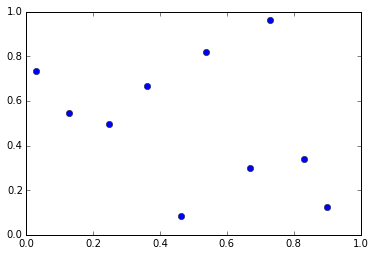

In [5]:
p = 2
n = 10
k = 500
D = maximin_lhc(k, p, n)
figure()
plot(D[0], D[1], 'o')
show()

30 2 3


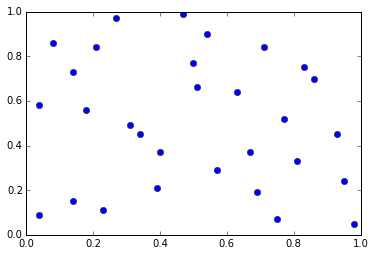

In [6]:
points = np.array([[0.86,0.27,0.57,0.5,0.14,0.23,0.39,0.93,0.98,0.54, 0.77,0.81,0.18,0.71,0.31,0.04,0.69,0.4,0.63,0.08, 0.34,0.04,0.83,0.21,0.67,0.47,0.14,0.51,0.75,0.95],
                   [0.7,0.97,0.29,0.77,0.73,0.11,0.21,0.45,0.05,0.9, 0.52,0.33,0.56,0.84,0.49,0.09,0.19,0.37,0.64,0.86, 0.45,0.58,0.75,0.84,0.37,0.99,0.15,0.66,0.07,0.24 ]], dtype=np.float_)
f_D = np.array([[11.81,-4.95,25.51,5.27,4.85,30.28,27.50,20.89,34.50,0.43, 17.59,25.27,13.39,3.67,16.50,29.96,29.78,21.14,12.78,-0.98, 17.99,12.11,9.10,1.03,22.71,-4.61,28.33,11.60,34.10,29.28]], dtype=np.float_).T
D = points#norm_points(points)
taus = np.array(zip(*product(np.linspace(-10, 5, 250), np.linspace(-10, 10, 250))), dtype=np.float_).T#np.vstack((np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))).T
n = D.shape[1]
p = D.shape[0]
q = 1 + p
delta_hat = np.array([0.4966, 0.1061], dtype=np.float_)
print n, p, q
figure()
plot(D[0], D[1], 'o')
show()

In [7]:
As = map(lambda s: A(D, np.exp(s/2.), p), taus)

In [8]:
A_invs = map(lambda a: np.matrix(a).getI(), As)

In [9]:
ln_pi_tau_star_pi = np.log(np.array(map(lambda (a_inv, a): pi_star_tau(n, q, f_D, a_inv, a, H(D, h)), zip(A_invs, As))).flatten())
show = np.isnan(ln_pi_tau_star_pi)
print len(taus[show])

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: invalid value encountered in power
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: divide by zero encountered in power


6732


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:161: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


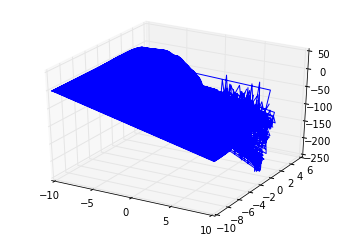

In [10]:
fig = figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(taus.T[1][~show], taus.T[0][~show], ln_pi_tau_star_pi[~show])
fig.show()

In [11]:
from scipy.optimize import basinhopping, minimize

def f(x):
    try:
        a = A(D, np.exp(x/2.), p)
        a_inv = np.matrix(a).getI()
    except:
        return 0.
    return -np.log(pi_star_tau(n, q, f_D, a_inv, a, H(D, h)))

delta_hat = np.exp(minimize(f, np.array([0.,0.]), method="nelder-mead", options={'disp':True})['x']/2.)
print delta_hat

Optimization terminated successfully.
         Current function value: -11.512261
         Iterations: 93
         Function evaluations: 173
[ 0.49632059  0.10587287]


In [12]:
A_inv = np.matrix(A(D, delta_hat, p)).getI()
b_hat = beta_hat(H(D, h), A_inv, f_D)
s_hat_sq = sigma_hat_sq(n, q, f_D, A_inv, H(D, h))[0,0]
H_ = H(D, h)

In [13]:
b_hat, s_hat_sq, sigma_hat_sq_beta(n, q, f_D, A_inv, H(D, h), b_hat)

(matrix([[ 33.5746759 ],
         [  4.99711037],
         [-39.72660153]]), 1.0312631440498869, matrix([[ 1.03126314]]))

In [14]:
t = make_t(D, delta_hat)
m_star = make_m_star(h, b_hat, A_inv, f_D, t)
v_star = make_v_star(s_hat_sq, delta_hat, A_inv, h, H_, t)

[[ 28.66731807]
 [  4.74596804]
 [ 15.00925228]
 [ 11.64455701]
 [ 20.48090827]
 [ 10.49950382]
 [ 18.94461876]
 [ 35.1970668 ]
 [ 26.54046169]
 [ -3.94234845]]
[ 0.16388127  0.21859495  0.28556801  0.2532957   0.25570205  0.21565019
  0.33641127  0.31668959  0.13691174  0.2027507 ]


TypeError: 'numpy.ndarray' object is not callable

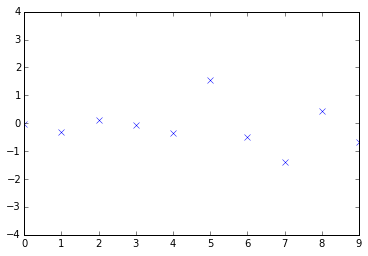

In [15]:
D_prime = np.array([[0.00,0.83,0.16,0.37,0.76,0.64,0.58,0.91,0.42,0.21],
[0.12,0.83,0.51,0.64,0.44,0.70,0.46,0.03,0.24,0.94]])
f_D_prime = np.array([[28.66,4.68,15.04,11.63,20.39,10.83,18.78,34.76,26.60,-4.08]]).T
m_star_D_prime = m_star(D_prime)
print m_star_D_prime
v_star_D_prime = v_star(D_prime, D_prime)
print np.sqrt(np.diag(v_star_D_prime))
ses = np.array(se(f_D_prime, m_star_D_prime, v_star_D_prime))
figure()
plot(range(0, 10), ses[0], 'x')
ylim([-4, 4])
show()

In [16]:
mahalanobis(f_D_prime, m_star_D_prime, v_star_D_prime)

matrix([[ 8.15511948]])

In [17]:
D = np.hstack((D, D_prime))
f_D = np.vstack((f_D, f_D_prime))
n = D.shape[1]
print n

40


In [18]:
def f(x):
    try:
        a = A(D, np.exp(x/2.), p)
        a_inv = np.matrix(a).getI()
    except:
        return 0.
    return -np.log(pi_star_tau(n, q, f_D, a_inv, a, H(D, h)))

def print_fun(x, f, accepted):
    print("at minima %.4f accepted %d" % (f, int(accepted)), x)

delta_hat = np.exp(minimize(f, np.array([-1.,-4.]), method="nelder-mead", options={'disp':True})['x']/2.)
print delta_hat
delta_hat = np.exp(basinhopping(f, np.array([-1.,-4.]), callback=print_fun)['x']/2.)
print delta_hat
#delta_hat = np.array([0.5437, 0.0961])
#delta_hat = np.exp(np.array([-1.2187, -4.6840])/2)

Optimization terminated successfully.
         Current function value: -29.331672
         Iterations: 33
         Function evaluations: 63
[ 0.54422048  0.09681317]
('at minima -29.3317 accepted 1', array([-1.21672722, -4.67003159]))
('at minima -29.3317 accepted 1', array([-1.21690489, -4.67000705]))
('at minima -29.3317 accepted 1', array([-1.21687169, -4.67026661]))
('at minima -29.3317 accepted 1', array([-1.21672948, -4.66989292]))
('at minima -29.3317 accepted 1', array([-1.21681492, -4.66991479]))
('at minima -29.3317 accepted 1', array([-1.21682831, -4.66990912]))
('at minima -27.0516 accepted 0', array([-1.55311522, -5.05567136]))
('at minima -29.3317 accepted 1', array([-1.21686311, -4.66990472]))
('at minima -29.3317 accepted 1', array([-1.21675827, -4.66996007]))
('at minima -29.3317 accepted 1', array([-1.21679105, -4.66993085]))
('at minima -29.3317 accepted 1', array([-1.21685582, -4.67016192]))
('at minima -26.8837 accepted 1', array([-1.38752421, -5.16269095]))
('at m

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: invalid value encountered in power
/usr/local/lib/python2.7/site-packages/scipy/optimize/optimize.py:556: RuntimeWarning: invalid value encountered in subtract
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


LinAlgError: singular matrix

In [21]:
print delta_hat
A_inv = np.matrix(A(D, delta_hat, p)).getI()
b_hat = beta_hat(H(D, h), A_inv, f_D)
s_hat_sq = sigma_hat_sq(n, q, f_D, A_inv, H(D, h))[0,0]
H_ = H(D, h)
t = make_t(D, delta_hat)
m_star = make_m_star(h, b_hat, A_inv, f_D, t)
v_star = make_v_star(s_hat_sq, delta_hat, A_inv, h, H_, t)
print b_hat, s_hat_sq, sigma_hat_sq_beta(n, q, f_D, A_inv, H(D, h), b_hat)

[ 0.54422048  0.09681317]
[[ 33.59685515]
 [  4.85740033]
 [-39.67529732]] 0.924413904443 [[ 0.9244139]]


In [22]:
B = np.asmatrix(np.array([[50, 0], [0, 50]]))
C = np.array([[np.power(delta_hat[0], -2.), 0], [0, np.power(delta_hat[1], -2.)]])
m = np.array([.5, .5])[:,np.newaxis]
v = 0.
E_X_h_x = np.vstack((1, m))
E_X_h_x_h_x = np.vstack((np.hstack(([[1]], m.T)), np.hstack((m, m.dot(m.T) + np.asmatrix(B).getI()))))

In [23]:
w = W(H_, A_inv)
g = G(A_inv, H_)
e_ = e(A_inv, f_D, H_, b_hat)
r_h = R_h(m)
r_t = np.array(map(lambda k: R_t(D, k, B, C, v, m), range(D.shape[1]))).flatten()[:,np.newaxis]
u = U(v, B, C)
E_ = E(r_h, b_hat, r_t, e_)
V_ = V(s_hat_sq, u, r_t, A_inv, r_h, g, w)

In [24]:
E_, V_

(matrix([[ 16.984513]]), matrix([[ 0.00161831]]))

In [25]:
r_tt = map(lambda k: map(lambda l: R_tt(D, k, l, C, B, m, v)[0,0], range(D.shape[1])), range(D.shape[1])) #matrix
r_hh = R_hh(m, B)
r_ht = reduce(lambda x, y: np.hstack((x, y)),map(lambda k: R_ht(D, k, B, C, v, m, h), range(D.shape[1]))) #matrix
i_1 = I_1(s_hat_sq, A_inv, r_tt, w, r_hh, r_ht, g)
i_2 = I_2(b_hat, r_hh, r_ht, e_, r_tt)
E_var_ = E_var(i_1, i_2, V_, E_)[0,0]
print E_var_

29.9709305002


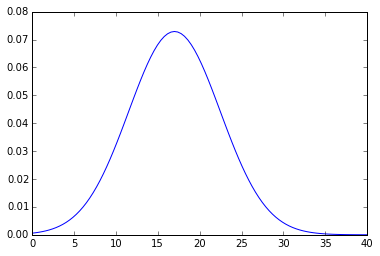

In [26]:
figure()
mean = E_[0,0]
variance = E_var_
sigma = math.sqrt(variance)
x = np.linspace(0,40,100)
plt.plot(x,mlab.normpdf(x,mean,sigma))

plt.show()

In [27]:
def R_w(m, x, w_bar, w):
    """
    1xq vector
    """
    #return np.hstack(([1], m.T[0, w_bar], x.T[0, w]))
    #return np.hstack(([1], x.T[0, w], m.T[0, w_bar]))
    indices = w+w_bar
    indices.sort()
    return np.hstack(([1], map(lambda k: x.T[0, k] if k in w else m.T[0, k], indices)))

def T_w(xw, x, b, c, m, w, w_bar, v, k):
    """
    1xn vector, R_t is a special case for w is empty
    """
    exp2 = np.exp(-0.5*(xw[w]-x[w,k]).T*2*c[w,w]*(xw[w]-x[w,k]))
    def exp1(i):
        return np.exp(-0.5*((2*c[i, i]*b[i, i])/(2*c[i, i] + b[i, i]))*np.power(x[i,k]-m[i], 2.))
    def div(i):
        return np.sqrt(b[i,i])/np.sqrt(2*c[i,i] + b[i,i])
    return (1 - v)*np.multiply.reduce(map(lambda i: div(i)*exp1(i)*exp2, w_bar))

def posterior_mean_m_w(r_w, b_hat, t_w, e_):
    return r_w.dot(b_hat) + t_w.dot(e_)

def posterior_mean_i(r_i, r_h, t_i, r_t, b_hat, e_):
    return (r_i - r_h.T).dot(b_hat) + (t_i - r_t.T).dot(e_)


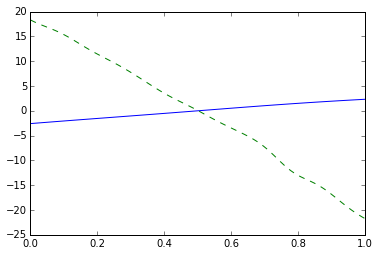

In [28]:
x = D
def calc(w, i):
    w_bar = [(w + 1) % 2]
    xw = np.array([0., 0.])
    xw[w] = i
    xw = xw[:,np.newaxis]
    r_w = R_w(m, xw, w_bar, [w])
    t_w = np.array(map(lambda k: T_w(xw, x, B, C, m, w, w_bar, v, k), range(x.shape[1]))).flatten()
    #return posterior_mean_m_w(r_w, b_hat, t_w, e_)
    return posterior_mean_i(r_w, r_h, t_w, r_t, b_hat, e_)

figure()
x_axis = np.linspace(0,1,100)
plt.plot(x_axis, map(lambda y: calc(0, y)[0, 0], x_axis))
plt.plot(x_axis, map(lambda y: calc(1, y)[0, 0], x_axis), '--')
plt.show()

In [29]:
w_bar = [0]
w = [1]
u_w = U_w(v, B, C, w_bar)
p_w = np.array(map(lambda k: map(lambda l: P_w(x, k, l, m, B, C, w), range(x.shape[1])), range(x.shape[1])))
s_w = np.array(map(lambda k: map(lambda l: S_w(k, l, w, w_bar, B, C, x, m, v)[0], range(x.shape[1])), range(q)))
q_w = Q_w(m, w, w_bar, B)
posterior_mean_v_w(sigma, b_hat, A_inv, e_, W(H_, A_inv), H_, u, u_w, p_w, q_w, r_h.T, r_t.T)

matrix([[ 29.44769557]])

In [46]:
w_bar = [1]
w = [0]
u_w = U_w(v, B, C, w_bar)
p_w = np.array(map(lambda k: map(lambda l: P_w(x, k, l, m, B, C, w), range(x.shape[1])), range(x.shape[1])))
s_w = np.array(map(lambda k: map(lambda l: S_w(k, l, w, w_bar, B, C, x, m, v)[0], range(x.shape[1])), range(q)))
q_w = Q_w(m, w, w_bar, B)
posterior_mean_v_w(sigma, b_hat, A_inv, e_, W(H_, A_inv), H_, u, u_w, p_w, q_w, r_h.T, r_t.T)

matrix([[ 0.53476379]])

In [34]:
s_w

array([[  1.23710620e-01,   3.98340877e-03,   1.64982624e-01,
          9.34193595e-02,   9.52654879e-02,   1.51216183e-02,
          7.18269633e-02,   2.24298019e-01,   3.41035197e-03,
          1.59300865e-02,   3.26577748e-01,   1.71128635e-01,
          2.80368090e-01,   3.45037644e-02,   3.66577793e-01,
          7.23896805e-03,   5.24478788e-02,   2.81907859e-01,
          2.61483012e-01,   1.75309431e-02,   3.60263113e-01,
          1.91437624e-01,   8.34129371e-02,   3.06331610e-02,
          2.66496128e-01,   3.15169583e-03,   2.32657942e-02,
          2.43427394e-01,   8.02633515e-03,   5.69447792e-02,
          1.04361345e-02,   3.25902935e-02,   2.89376162e-01,
          2.61483012e-01,   3.10946407e-01,   1.71598037e-01,
          3.88454579e-01,   2.82769026e-03,   1.02044350e-01,
          6.31081946e-03],
       [  6.18553099e-02,   1.99170439e-03,   8.24913119e-02,
          4.67096798e-02,   4.76327440e-02,   7.56080913e-03,
          3.59134817e-02,   1.12149009e-01,

In [33]:
p_w

array([[[  5.39155870e-02],
        [  2.75378992e-04],
        [  2.43670291e-05],
        ..., 
        [  3.11573718e-12],
        [  2.33646899e-06],
        [  7.07259632e-04]],

       [[  2.75378992e-04],
        [  1.48515074e-03],
        [  3.18853464e-12],
        ..., 
        [  4.99703235e-22],
        [  8.42206029e-14],
        [  1.75978843e-03]],

       [[  2.43670291e-05],
        [  3.18853464e-12],
        [  1.03290205e-01],
        ..., 
        [  3.48491667e-04],
        [  7.01586147e-02],
        [  2.65092756e-11]],

       ..., 
       [[  3.11573718e-12],
        [  4.99703235e-22],
        [  3.48491667e-04],
        ..., 
        [  7.48383934e-04],
        [  8.19230932e-04],
        [  8.75052537e-21]],

       [[  2.33646899e-06],
        [  8.42206029e-14],
        [  7.01586147e-02],
        ..., 
        [  8.19230932e-04],
        [  6.05053332e-02],
        [  8.08052424e-13]],

       [[  7.07259632e-04],
        [  1.75978843e-03],
        [  